In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import copy


In [2]:
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_68k_Zheng/Zheng_PBMC.h5ad')
adata.shape

(68579, 32738)

In [3]:
adata.obs.head()

,celltype,TSNE.1,TSNE.2
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970


In [4]:
adata.var.head()

,gene_symbols
ENSG00000243485,MIR1302-10
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8


## Quality control
(did not actually filter out cells)

In [5]:
# Calculate quality control metrics
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var['gene_symbols'].str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

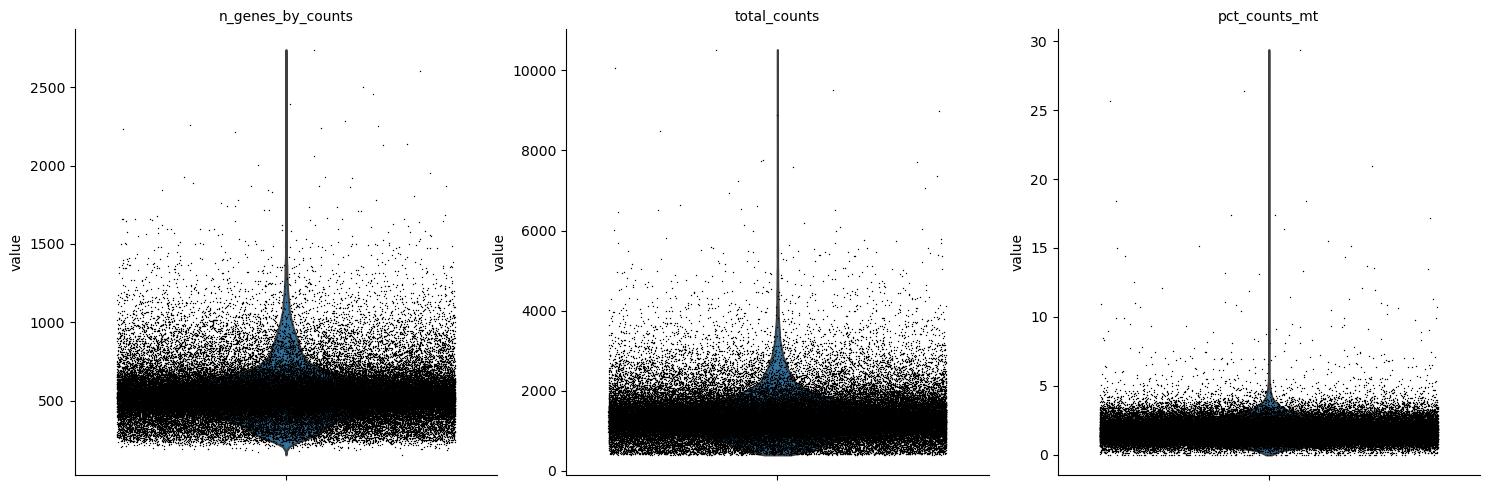

In [6]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

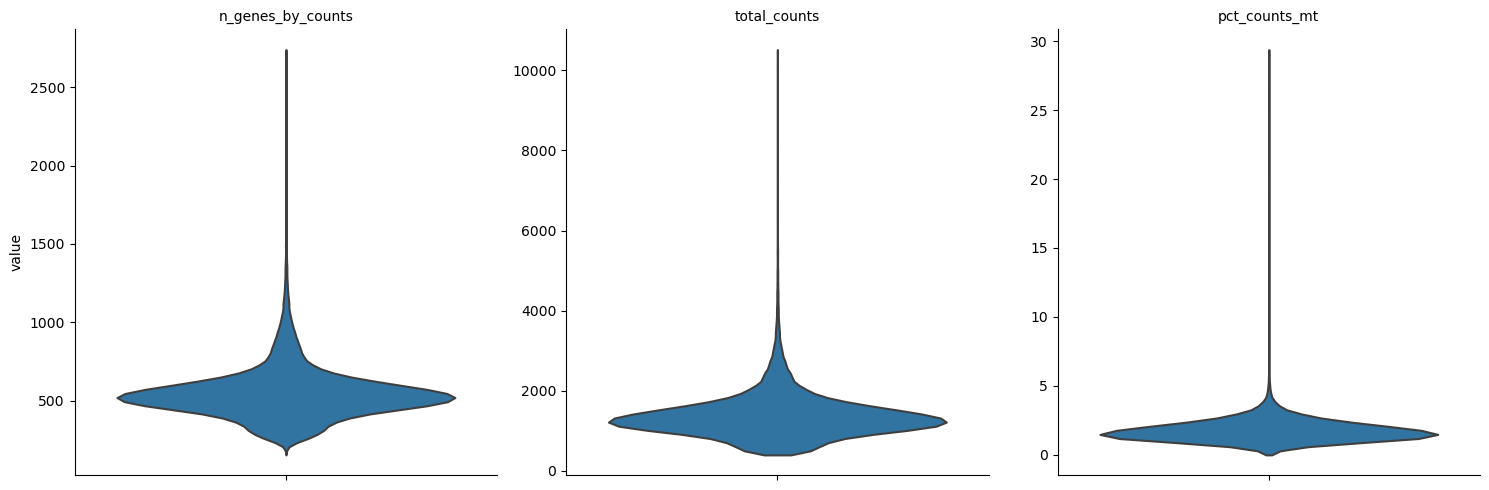

In [7]:
# quality control violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             stripplot=False, multi_panel=True)

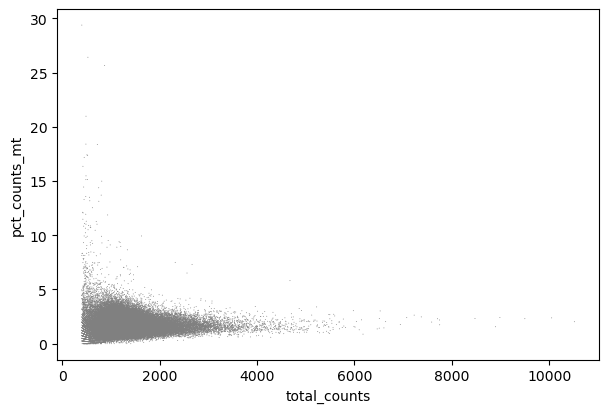

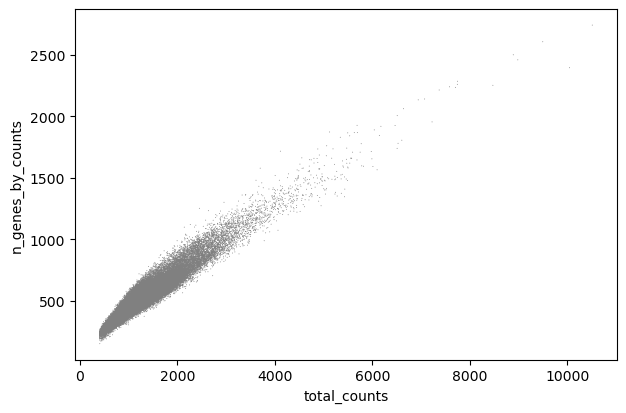

In [8]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [9]:
# filtering out the low quality cells
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## Normalization

In [10]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## HVG

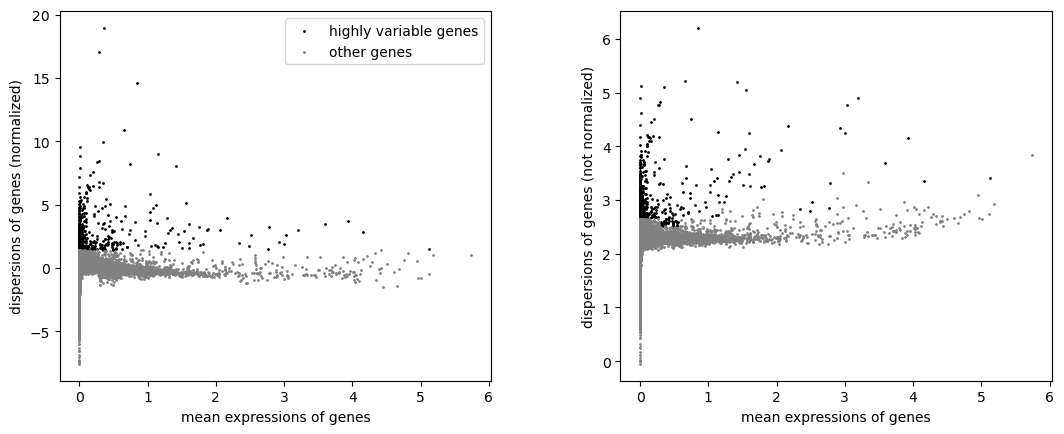

In [11]:
# HVG1000
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
sc.pl.highly_variable_genes(adata)

In [12]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression
adata.raw = adata

In [13]:
adata_HVG1000 = adata[:, adata.var.highly_variable]
adata_HVG1000.shape

(68579, 1000)

In [15]:
# regress out the unwanted sources of variation
# sc.pp.regress_out(adata_HVG1000, ['total_counts', 'pct_counts_mt'])
# Scale each gene to unit variance
# sc.pp.scale(adata_HVG1000, max_value=10)

## PCA

In [19]:
sc.tl.pca(adata_HVG1000, svd_solver="arpack")

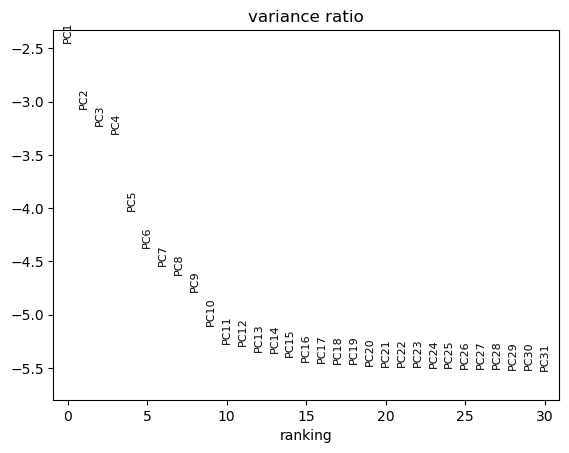

In [20]:
sc.pl.pca_variance_ratio(adata_HVG1000, log=True)

## UMAP

In [21]:
# neighborhood graph
sc.pp.neighbors(adata_HVG1000, n_neighbors=10, n_pcs=50)

In [ ]:
# sc.tl.paga(adata_HVG1000)
# sc.pl.paga(adata_HVG1000, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata_HVG1000, init_pos='paga')

In [23]:
sc.tl.umap(adata_HVG1000)

In [24]:
adata_HVG1000.obs.head()

,celltype,TSNE.1,TSNE.2,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACACCCAA-1,CD8+ Cytotoxic T,7.565540,0.441370,498,1216.0,27.0,2.220395
AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic,2.552626,-25.786672,472,1265.0,31.0,2.450593
AAACATACCGGAGA-1,CD4+/CD45RO+ Memory,-5.771831,11.830846,542,1322.0,20.0,1.512859
AAACATACTAACCG-1,CD19+ B,1.762556,25.979346,349,854.0,9.0,1.053864
AAACATACTCTTCA-1,CD4+/CD25 T Reg,-16.793856,-16.589970,446,1252.0,22.0,1.757189


/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


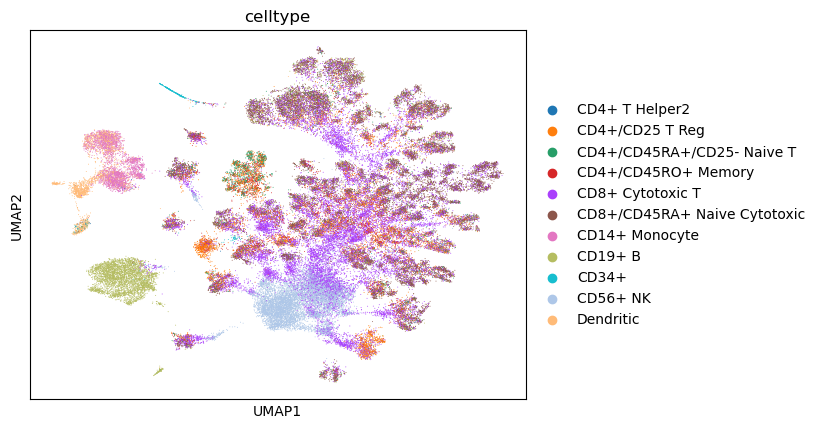

In [25]:
sc.pl.umap(adata_HVG1000, color='celltype')

## UMAP (all genes)

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


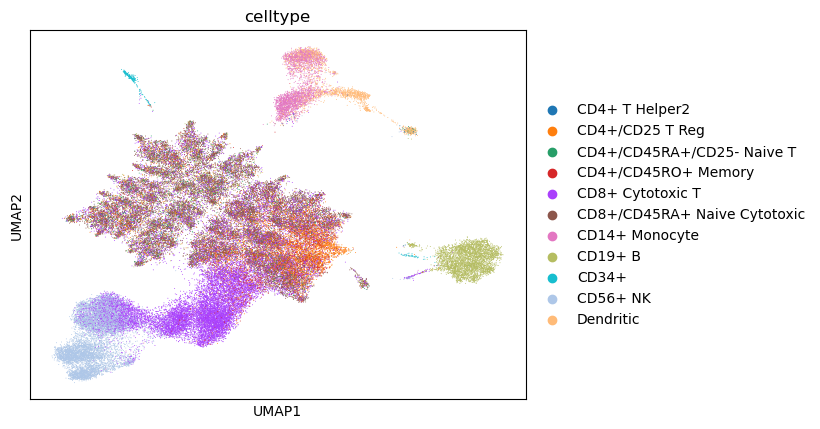

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='celltype')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


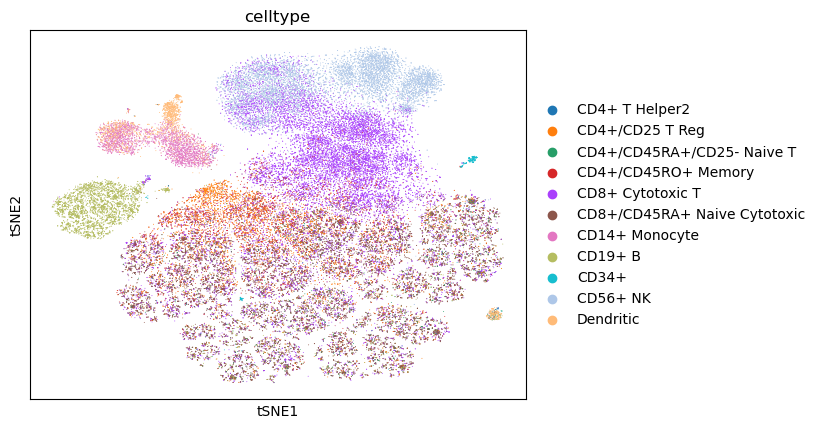

In [28]:
sc.tl.tsne(adata, random_state=0)
sc.pl.tsne(adata, color='celltype')


## Leiden

In [26]:
sc.tl.leiden(
    adata_HVG1000,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.